<a href="https://colab.research.google.com/github/NahianAlindo/gait_recognition/blob/main/Model_with_increased_LSTM_blocks_TPU_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive and Accelerator status

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import os
try:
    tpu = False
    assert torch.cuda.is_available()
    gpu = True
    ! nvidia-smi
except:
    tpu = True
    gpu = False
    if 'COLAB_TPU_ADDR' not in os.environ:
        print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
    else:
        tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
        print ('TPU address is', tpu_address)
    import tensorflow as tf
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
    strategy = tf.distribute.TPUStrategy(resolver)

Tue Dec  7 11:46:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install keras_tuner

     |████████████████████████████████| 98 kB 3.7 MB/s 


# Import Libraries

In [ ]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
# import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.constraints import max_norm as maxnorm
import seaborn as sns
import tensorflow.keras.metrics as metrics
import tensorflow.keras as keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Utility Functions for loading dataset, plots and performance

In [ ]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [ ]:
def get_test_performance(model, X_test, test_label):
    score=model.evaluate(X_test,test_label,verbose=1)
    print(f'Test loss:{score[0]}')
    print(f'Test accuracy:{score[1]}')
    print(f'Test Recall: {score[3]}')
    print(f'Test AUC: {score[2]}')

In [ ]:
def plot_performance(X_train, train_label, history):
    plt.plot(history.history['accuracy'])
    try:
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
    except:
        pass
    try:
        plt.legend(['val'], loc='upper left')
    except:
        pass
    plt.show()

    plt.plot(history.history['loss'])
    try:
        plt.plot(history.history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    try:
        plt.legend(['train'], loc='upper left')
    except:
        pass
    plt.show()

In [ ]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# Tuner

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
def post_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Choice('lstm_1', values = [8,16,32,64,128,256,512]),return_sequences=True)(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    x = LSTM(units=hp.Choice('lstm_2', values = [8,16,32,64,128,256,512]))(x)
    x = Dropout(hp.Choice(name='Dropout_2', values = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_1_filter_size', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_2_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512,]), hp.Choice(name='conv_3_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    # batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    if gpu:
        opt = keras.optimizers.Adam(learning_rate=0.001)
    if tpu:
        opt = keras.optimizers.Adam(learning_rate=8*0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

# Tune on 90% data

In [ ]:
if gpu:
    tuner = kt.tuners.BayesianOptimization(post_se,
        objective='val_accuracy',
        max_trials=30,
        seed=42,
        project_name='Model_gpu')
    # Will stop training if the "val_loss" hasn't improved in 30 epochs.
    tuner.search(X_train, train_label, epochs=200, validation_split=0.1, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

if tpu:
    print("TPU")
    with strategy.scope():
        tuner = kt.tuners.BayesianOptimization(post_se,
            objective='val_accuracy',
            max_trials=30,
            seed=42,
            project_name='Model_tpu')
        # Will stop training if the "val_loss" hasn't improved in 30 epochs.
        tuner.search(X_train, train_label, epochs=200, validation_split=0.1, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

Trial 4 Complete [01h 14m 12s]
val_accuracy: 0.9948655962944031

Best val_accuracy So Far: 0.9957716464996338
Total elapsed time: 04h 58m 55s

Search: Running Trial #5

Hyperparameter    |Value             |Best Value So Far 
lstm_1            |8                 |32                
Dropout           |0                 |0.3               
lstm_2            |8                 |16                
Dropout_2         |0                 |0.1               
conv_1_filter     |512               |512               
conv_1_filter_size|3                 |3                 
conv_2_filter     |512               |512               
conv_2_filter_size|9                 |5                 
conv_3_filter     |512               |128               
conv_3_filter_size|9                 |8                 

Epoch 1/200
932/932 [==============================] - 103s 99ms/step - loss: 0.7808 - accuracy: 0.8101 - val_loss: 0.2039 - val_accuracy: 0.9393
Epoch 2/200
932/932 [==============================] - 89

# MODEL DEFINITION

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=32, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(units=16)(x)
    x = Dropout(0.1)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(512, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

# Train on 90% data Dataset 1

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     9728        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                                                                   

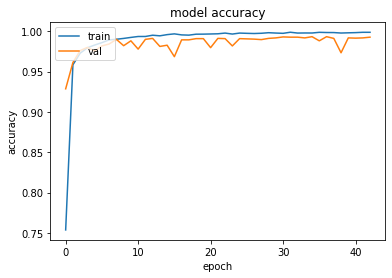

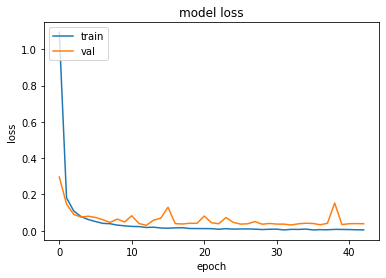

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 2s 21ms/step - loss: 0.5039 - accuracy: 0.9428 - auc: 0.9805 - recall: 0.9404
Test loss:0.5039483904838562
Test accuracy:0.9427807331085205
Test Recall: 0.9403743147850037
Test AUC: 0.9805034399032593


# Train Full Manually Dataset 1

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 512)     9728        ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 512)    2048        ['conv1d_6[0][0]']               
 rmalization)                                                                               

KeyError: ignored

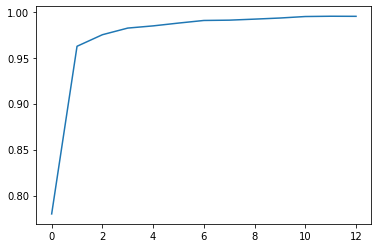

In [ ]:
epochs = 13
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

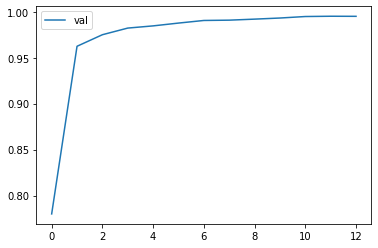

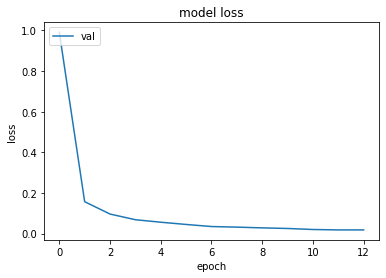

In [ ]:
plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 65s 22ms/step - loss: 0.4629 - accuracy: 0.9342 - auc: 0.9817 - recall: 0.9286
Test loss:0.4629306495189667
Test accuracy:0.9342246055603027
Test Recall: 0.9286096096038818
Test AUC: 0.9816535711288452


# Train 90%  Dataset 2

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 4s 23ms/step - loss: 0.1883 - accuracy: 0.9751 - auc: 0.9898 - recall: 0.9751
Test loss:0.18830275535583496
Test accuracy:0.9750810265541077
Test Recall: 0.9750810265541077
Test AUC: 0.9898303151130676


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


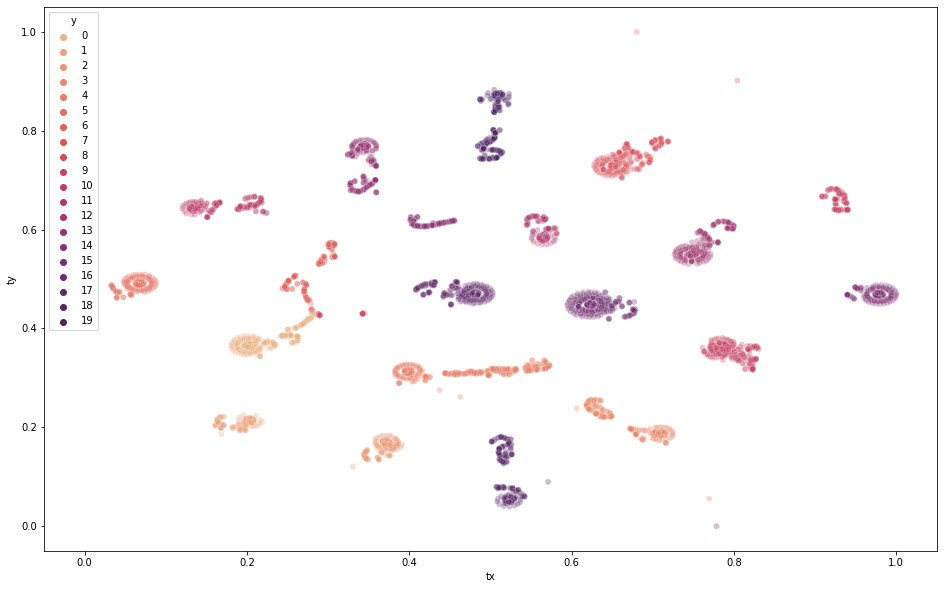

In [ ]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
features = model.predict(X_test)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features)
import pandas as pd
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))

    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
tx = list(tx)
ty = list(ty)

data = {'tx':tx,
        'ty':ty}
df = pd.DataFrame(data)
df['y'] = y_classes
# fig = plt.figure()

# ax = fig.add_subplot(111)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tx", y="ty",
    hue="y",
    palette=sns.color_palette("flare", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

# Train Full Manually Dataset 2

In [ ]:
epochs = 34
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

NameError: ignored

In [ ]:
get_test_performance(model, X_test, test_label)

In [ ]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
features = model.predict(X_test)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features)
import pandas as pd
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))

    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
tx = list(tx)
ty = list(ty)

data = {'tx':tx,
        'ty':ty}
df = pd.DataFrame(data)
df['y'] = y_classes
# fig = plt.figure()

# ax = fig.add_subplot(111)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tx", y="ty",
    hue="y",
    palette=sns.color_palette("flare", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

# Train 90%  Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     9728        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                              

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 512)     9728        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 512)    2048        ['conv1d_3[0][0]']               
 rmalization)                                                                               

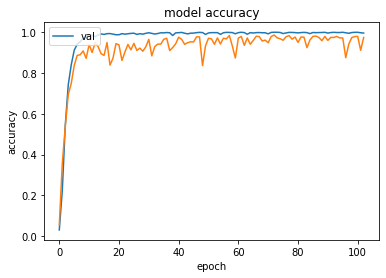

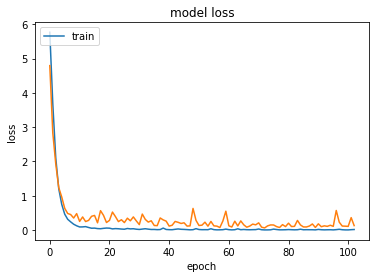

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 28ms/step - loss: 0.2381 - accuracy: 0.9503 - auc: 0.9929 - recall: 0.9439
Test loss:0.2380935698747635
Test accuracy:0.9503193497657776
Test Recall: 0.9439318776130676
Test AUC: 0.992887556552887


# Train Full Manually Dataset OU-ISIR

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 512)     9728        ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 512)    2048        ['conv1d_6[0][0]']               
 rmalization)                                                                               

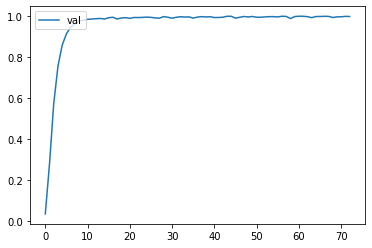

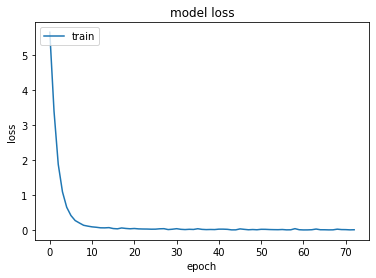

In [ ]:
epochs = 73
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 5s 26ms/step - loss: 0.1464 - accuracy: 0.9588 - auc: 0.9961 - recall: 0.9553
Test loss:0.14643196761608124
Test accuracy:0.9588360786437988
Test Recall: 0.9552874565124512
Test AUC: 0.9960893392562866


# Train Dataset 1 test=val

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     9728        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                                                                   

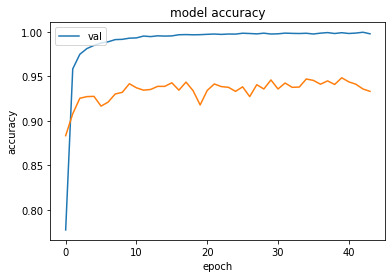

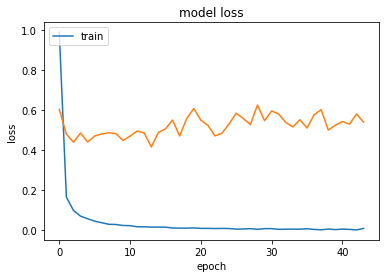

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 3s 24ms/step - loss: 0.5393 - accuracy: 0.9332 - auc: 0.9804 - recall: 0.9310
Test loss:0.5392704606056213
Test accuracy:0.9331550598144531
Test Recall: 0.9310160279273987
Test AUC: 0.9803583025932312


# Train dataset 2 test = val

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 512)     9728        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 512)    2048        ['conv1d_3[0][0]']               
 rmalization)                                                                               

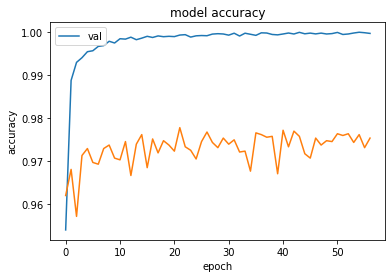

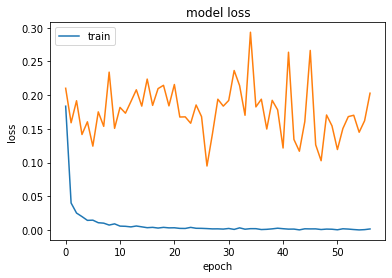

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 3s 22ms/step - loss: 0.2029 - accuracy: 0.9753 - auc: 0.9900 - recall: 0.9747
Test loss:0.2029436081647873
Test accuracy:0.9752836227416992
Test Recall: 0.9746758341789246
Test AUC: 0.9899775385856628


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


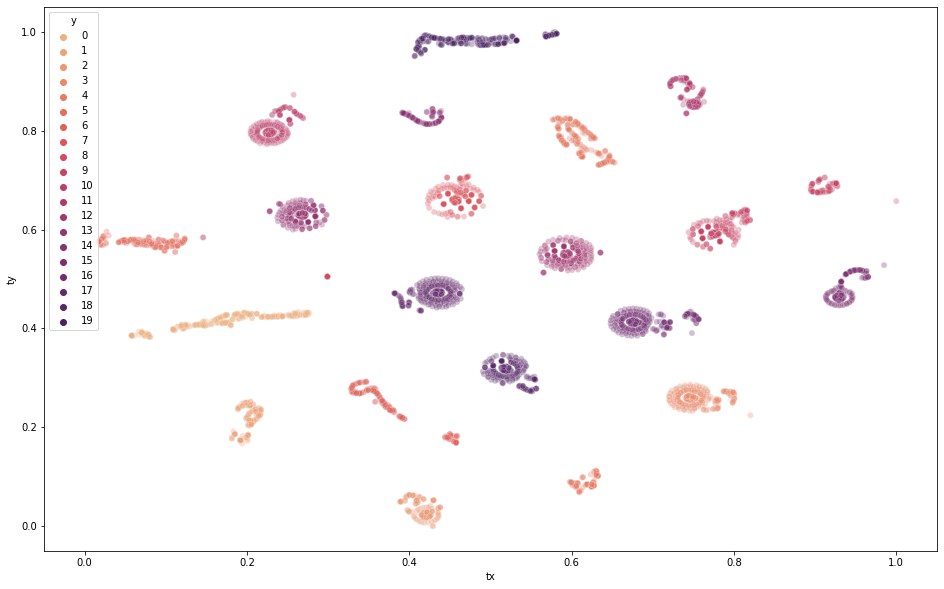

In [ ]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
features = model.predict(X_test)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features)
import pandas as pd
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))

    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
tx = list(tx)
ty = list(ty)

data = {'tx':tx,
        'ty':ty}
df = pd.DataFrame(data)
df['y'] = y_classes
# fig = plt.figure()

# ax = fig.add_subplot(111)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tx", y="ty",
    hue="y",
    palette=sns.color_palette("flare", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

#Train Test = val Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 512)     9728        ['permute_3[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 512)    2048        ['conv1d_9[0][0]']               
 rmalization)                                                                               

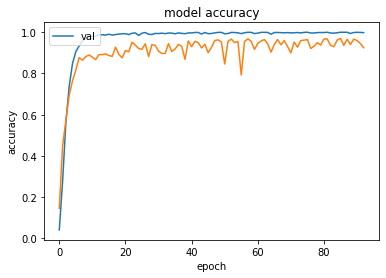

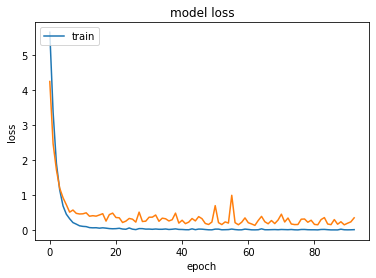

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 26ms/step - loss: 0.3453 - accuracy: 0.9248 - auc: 0.9886 - recall: 0.9212
Test loss:0.34529170393943787
Test accuracy:0.9247693419456482
Test Recall: 0.9212207198143005
Test AUC: 0.9886131882667542


# Tuned config on all

# Tune Test = val 

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
def post_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Choice('lstm_1', values = [8,16,32,64,128,256,512]),return_sequences=True)(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    x = LSTM(units=hp.Choice('lstm_2', values = [8,16,32,64,128,256,512]))(x)
    x = Dropout(hp.Choice(name='Dropout_2', values = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_1_filter_size', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_2_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512,]), hp.Choice(name='conv_3_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    # batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    if gpu:
        opt = keras.optimizers.Adam(learning_rate=0.001)
    if tpu:
        opt = keras.optimizers.Adam(learning_rate=8*0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

In [ ]:
if gpu:
    tuner = kt.tuners.BayesianOptimization(post_se,
        objective='val_accuracy',
        max_trials=30,
        seed=42,
        project_name='Model_gpu_test')
    # Will stop training if the "val_loss" hasn't improved in 30 epochs.
    tuner.search(X_train, train_label, epochs=200, validation_data=(X_test,test_label), shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

if tpu:
    with strategy.scope():
        tuner = kt.tuners.BayesianOptimization(post_se,
            objective='val_accuracy',
            max_trials=30,
            seed=42,
            project_name='Model_tpu_test')
        # Will stop training if the "val_loss" hasn't improved in 30 epochs.
        tuner.search(X_train, train_label, epochs=200, validation_data=(X_test,test_label), shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

Trial 8 Complete [00h 43m 52s]
val_accuracy: 0.9505347609519958

Best val_accuracy So Far: 0.9513369202613831
Total elapsed time: 06h 09m 58s

Search: Running Trial #9

Hyperparameter    |Value             |Best Value So Far 
lstm_1            |8                 |16                
Dropout           |0                 |0                 
lstm_2            |256               |8                 
Dropout_2         |0.8               |0.8               
conv_1_filter     |512               |512               
conv_1_filter_size|3                 |3                 
conv_2_filter     |512               |512               
conv_2_filter_size|3                 |3                 
conv_3_filter     |512               |512               
conv_3_filter_size|9                 |9                 

Epoch 1/200
1035/1035 [==============================] - 90s 77ms/step - loss: 0.7340 - accuracy: 0.8204 - val_loss: 0.5771 - val_accuracy: 0.9035
Epoch 2/200
1035/1035 [==============================] -

# MODEL DEFINITION

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=16, return_sequences=True)(x)
    x = Dropout(0)(x)
    x = LSTM(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(512, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

# Train Dataset 1 test=val

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     9728        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                                                                   

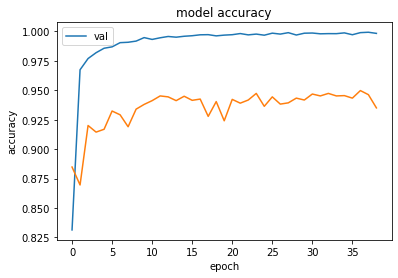

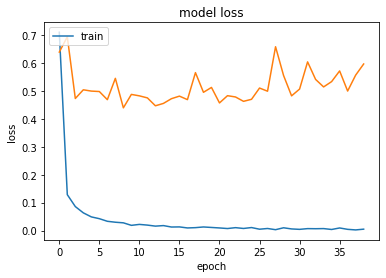

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 3s 26ms/step - loss: 0.5955 - accuracy: 0.9350 - auc: 0.9787 - recall: 0.9345
Test loss:0.5955348610877991
Test accuracy:0.9350267648696899
Test Recall: 0.9344919919967651
Test AUC: 0.97873455286026


# Train dataset 2 test = val

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 512)     9728        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 512)    2048        ['conv1d_3[0][0]']               
 rmalization)                                                                               

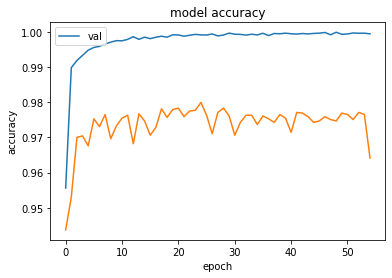

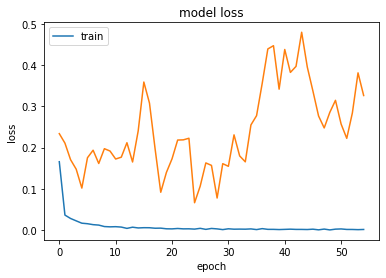

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 4s 24ms/step - loss: 0.3261 - accuracy: 0.9641 - auc: 0.9884 - recall: 0.9639
Test loss:0.32611948251724243
Test accuracy:0.9641410112380981
Test Recall: 0.9639384150505066
Test AUC: 0.9884015321731567


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


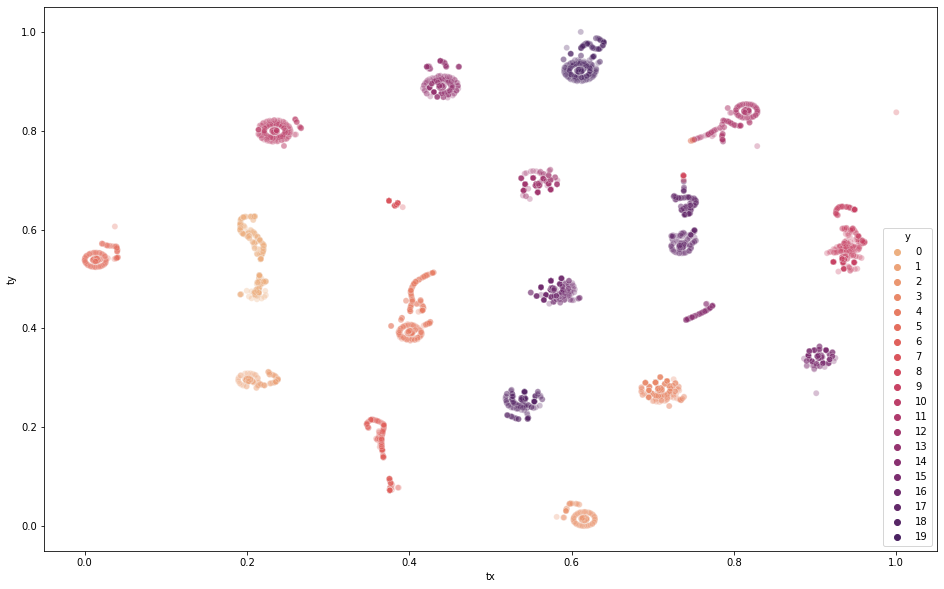

In [ ]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
features = model.predict(X_test)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features)
import pandas as pd
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))

    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
tx = list(tx)
ty = list(ty)

data = {'tx':tx,
        'ty':ty}
df = pd.DataFrame(data)
df['y'] = y_classes
# fig = plt.figure()

# ax = fig.add_subplot(111)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tx", y="ty",
    hue="y",
    palette=sns.color_palette("flare", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

#Train Test = val Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     9728        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                              

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 512)     9728        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 512)    2048        ['conv1d_3[0][0]']               
 rmalization)                                                                               

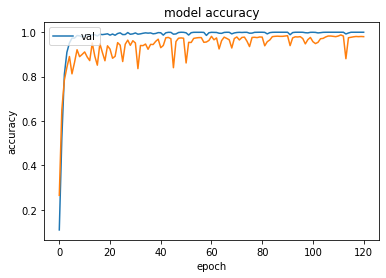

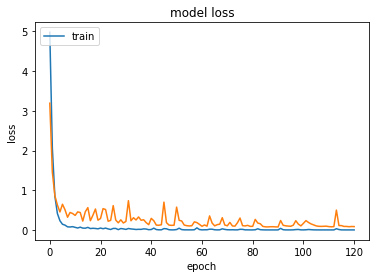

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 26ms/step - loss: 0.0836 - accuracy: 0.9801 - auc: 0.9972 - recall: 0.9794
Test loss:0.08355571329593658
Test accuracy:0.98012775182724
Test Recall: 0.9794180393218994
Test AUC: 0.9971582889556885
